In [240]:
import random
import numpy as np
import torch
import torchaudio
import tensorflow as tf

In [241]:
import pandas as pd
import soundfile as sf
import IPython.display as ipd

import os
import sys

In [242]:
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa.display 
import librosa

import seaborn as sns
import matplotlib.pyplot as plt

In [243]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

In [244]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
# from sklearn.model_selection import train_test_split

In [245]:
Tess_dataset = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
tess_directory_list = os.listdir(Tess_dataset)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess_dataset + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess_dataset + dir + '/' + file)

In [246]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [247]:
Tess_df
Tess_df['Emotions'].unique()
Tess_df.shape

(2800, 2)

WAV file initial:  Fs = 24414, x.shape = (34145,), x.dtype = float32


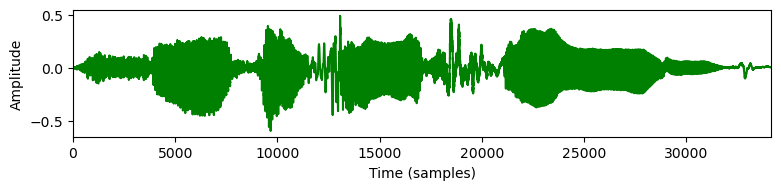

WAV file after normalization:  Fs = 24414, x.shape = (34145,), x.dtype = float32


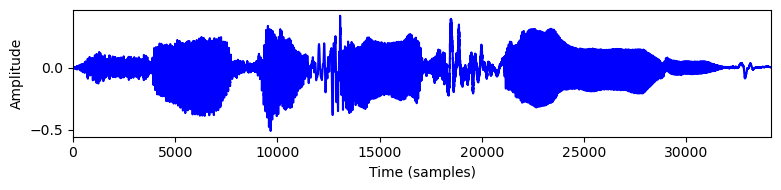

In [248]:
# # RMS normalization
def normalize(sig, fs, rms_level, i):
    """
    Normalize the signal given a certain technique (peak or rms).
    Args:
    - infile    (str) : input filename/path.
    - rms_level (int) : rms level in dB.
    """
    
    # linear rms level and scaling factor
    r = 10**(rms_level / 10.0)
    a = np.sqrt( (len(sig) * r**2) / np.sum(sig**2) )

    # normalize
    y = sig * a
    return y, fs
    
def print_plot_play(x, Fs, text='', color=''):
    """1. Prints information about an audio singal, 2. plots the waveform, and 3. Creates player
    
    Notebook: C1/B_PythonAudio.ipynb
    
    Args: 
        x: Input signal
        Fs: Sampling rate of x    
        text: Text to print
    """
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color=color)
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))
    
infile = Tess_df.iat[0, 1]
x, Fs = librosa.load(infile, sr=None)
print_plot_play(x=x, Fs=Fs, text='WAV file initial: ', color = 'green')

y, Fs = normalize(x, Fs, -10, 0)

# x, Fs = librosa.load("C:/Users/aditi/Downloads/Tess/Tess_Output_file0.wav", sr=None)
print_plot_play(x=y, Fs=Fs, text='WAV file after normalization: ', color = 'blue')

Original WAV file:  Fs = 24414, x.shape = (34145,), x.dtype = float32


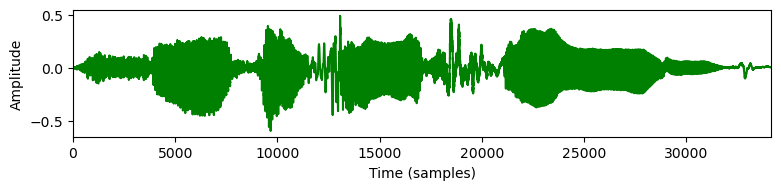

WAV file after Pre emphasis:  Fs = 24414, x.shape = (34145,), x.dtype = float32


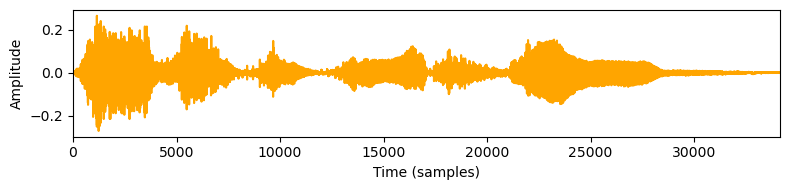

In [249]:
# Pre emphasis 
def preemphasis(signal, alpha=0.97):
    # Apply a first-order high-pass filter (pre-emphasis)
    preemphasized_signal = signal.copy()
    preemphasized_signal[1:] -= alpha * signal[:-1]
    return preemphasized_signal

infile = Tess_df.iat[0, 1]
x, Fs = librosa.load(infile, sr=None)
print_plot_play(x=x, Fs=Fs, text='Original WAV file: ', color = 'green')
# Apply pre-emphasis to the speech signal
preemphasized_signal = preemphasis(x)

# Save the pre-emphasized speech to a WAV file
# write_wav('preemphasized_speech.wav', fs, preemphasized_signal.astype(np.int16))
print_plot_play(x=preemphasized_signal, Fs=Fs, text='WAV file after Pre emphasis: ', color = 'orange')

In [250]:
def pre_features_creator():
    lst = []
    for i in range (0, 2800):
        infile = Tess_df.iat[i, 1]
        x, Fs = librosa.load(infile, sr=None)
        x, Fs = normalize(x, Fs, -10, 0)
        x = preemphasis(x)

        # Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        #X, fs = librosa.load(Tess_df.iat[i, 1], sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=x, sr=Fs,n_mfcc=40).T, axis=0)
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        arr = mfccs, Tess_df.iat[i, 0]   
        lst.append(arr)
    return lst 

In [251]:
lst = pre_features_creator()

In [252]:
# print(len(lst[0][0]))
# for i in range(450, 550):
#     print(len(lst[i][0]))

In [253]:
length = len(lst[0][0])
print(length)

40


In [254]:
# Define crossover function
def crossover(mfcc1, mfcc2, emotion):
    child_lst = []
    crossover_point = random.randint(0, 39)
    new_mfcc1 = np.concatenate((mfcc1[:crossover_point], mfcc2[crossover_point:]), axis=0)
    new_mfcc2 = np.concatenate((mfcc2[:crossover_point], mfcc1[crossover_point:]), axis=0)
    arr1 = new_mfcc1, emotion
    arr2 = new_mfcc2, emotion

    child_lst.append(arr1)
    child_lst.append(arr2)

    return child_lst

# Define mutation function
def mutation(child_lst, mutation_factor):
    child_lst2 = []
    for child in child_lst:
        mfcc = child[0]
        length = len(mfcc)
        num_mutations = int(length * mutation_factor)
        indices = np.random.randint(0, length, num_mutations)
        values = np.random.uniform(-1, 1, num_mutations)
        audio_mutated = np.copy(mfcc)
        audio_mutated[indices] = values
        child_lst2.append(audio_mutated)
    return child_lst2

In [255]:
# for i in range(2):
#     print(len(child_lst[i][0]))

In [256]:
# # Load the pre-trained model
# model = tf.keras.models.load_model('/kaggle/input/mymodels2/SER_model_2.h5')

# # Define the fitness function
# def fitness(mfcc, emotion):
#     loss, acc = model.evaluate(mfcc, 1)
#     return acc

In [257]:
# best_lst = []
# for r in range(len(lst)):
#     if(lst[r][1] == lst[r+1][1]):
#         emotion = lst[r][1]
#         for i in range(2):
#             mfcc1 = lst[r][0]
#             mfcc2 = lst[r+1][0]
#             child_lst = crossover(mfcc1, mfcc2, emotion)
#         child_lst2 = mutation(child_lst, 0.2)
#         max = 0
#         for child in child_lst2:
#             acc = fitness(child[0], child[1])
#             if(acc > max):
#                 max = acc
#                 arr = child[0], child[1]
#     best_lst.append(arr)

In [258]:
df = pd.DataFrame(columns=['child', 'emotion'])
j=0
for r in range(len(lst)-1):
    if(lst[r][1] == lst[r+1][1]):
        emotion = lst[r][1]
        for i in range(2):
            mfcc1 = lst[r][0]
            mfcc2 = lst[r+1][0]
            child_lst = crossover(mfcc1, mfcc2, emotion)
        child_lst2 = mutation(child_lst, 0.2)
        
    df.loc[j, 'child'] = child_lst2[0]
    df.loc[j+1, 'child'] = child_lst2[1]

    df.loc[j, 'emotion'] = emotion
    df.loc[j+1, 'emotion'] = emotion
#     df.loc[j+2, 'emotion'] = emotion
#     df.loc[j+3, 'emotion'] = emotion
    j = j+4
#     final_lst.append(child_lst2[0])
#     final_lst.append(child_lst2[1])
#     final_lst.append(child_lst2[2])
#     final_lst.append(child_lst2[3])

In [259]:
print(df.shape)
dfnumpy = np.array(df['child'])
dfnumpy.shape

(5598, 2)


(5598,)

In [260]:
dfnumpy.shape[0]

5598

In [261]:
len(lst)

2800

In [262]:
inp = np.array(lst[0][0])
ninp = np.reshape(inp, (1, 5, 8))
print(ninp)
print(ninp.shape)

[[[-361.0012      -27.922941     -7.1362557     7.6149144   -15.892626
     -6.781784      1.8955677    -5.259907  ]
  [ -10.9018545     4.0182085   -14.840773    -10.969567     -1.1254292
      0.7602987    -6.618675     -1.3334415 ]
  [  -9.3000345    -1.8863196     6.1766896     8.57643      15.267156
     18.015661      3.0096767     1.905761  ]
  [  -2.1026757    -1.5716588     6.128916     -0.628907     -5.0600495
     -5.999216     -2.457279     -1.4781972 ]
  [   3.3427603    -5.369539     -6.114096     -1.3206887     0.7799999
      0.49090433   -0.6570308     6.709906  ]]]
(1, 5, 8)


In [263]:
# x_train = np.array(lst[0])
x_train = []
for i in range(len(lst)):
    inp = np.array(lst[i][0])
    ninp = np.reshape(inp, (1, 5, 8))
    x_train.append(ninp)

In [264]:
x_train[0]

array([[[-361.0012    ,  -27.922941  ,   -7.1362557 ,    7.6149144 ,
          -15.892626  ,   -6.781784  ,    1.8955677 ,   -5.259907  ],
        [ -10.9018545 ,    4.0182085 ,  -14.840773  ,  -10.969567  ,
           -1.1254292 ,    0.7602987 ,   -6.618675  ,   -1.3334415 ],
        [  -9.3000345 ,   -1.8863196 ,    6.1766896 ,    8.57643   ,
           15.267156  ,   18.015661  ,    3.0096767 ,    1.905761  ],
        [  -2.1026757 ,   -1.5716588 ,    6.128916  ,   -0.628907  ,
           -5.0600495 ,   -5.999216  ,   -2.457279  ,   -1.4781972 ],
        [   3.3427603 ,   -5.369539  ,   -6.114096  ,   -1.3206887 ,
            0.7799999 ,    0.49090433,   -0.6570308 ,    6.709906  ]]],
      dtype=float32)

In [265]:
inp = np.array(dfnumpy[0])
print(inp.shape)
ninp = np.reshape(inp, (1, 40))
print(ninp.shape)
print(ninp)
print(inp.shape[0])

(40,)
(1, 40)
[[-3.61001190e+02 -2.79229412e+01 -7.13625574e+00  7.61491442e+00
  -1.58926258e+01 -6.78178406e+00  9.81790841e-01  6.44644380e-01
  -1.09018545e+01 -3.66098356e+00 -1.56135693e+01 -1.75566447e+00
  -3.04834747e+00  1.62051871e-01 -2.06677580e+00  3.43154573e+00
  -6.58396196e+00  9.82858086e+00  6.13061810e+00 -7.11418033e-01
   1.61609840e+01  1.61089935e+01  6.03726149e+00  4.11920881e+00
  -2.09911203e+00 -3.60217857e+00 -3.70234519e-01  1.20418513e+00
  -9.67076898e-01 -4.23854399e+00 -1.85227931e+00  3.72171283e+00
   7.78572750e+00  2.43031740e+00 -5.90932703e+00 -7.16673279e+00
   1.19881451e+00  3.22271037e+00 -3.97204161e-01  7.69099057e-01]]
40


In [266]:
x_aug = []
for i in range(dfnumpy.shape[0]):
    inp = np.array(dfnumpy[i])
    ninp = np.reshape(inp, (1, 40))
    x_aug.append(ninp)

In [267]:
# final_xx = df['first'].apply(lambda x: final_x)

In [268]:
# X = [x for x in final_xx]
# X = np.array(X)
# X.shape
# fear   [1. 0. 0. 0. 0. 0. 0.]
# angry  [0. 0. 1. 0. 0. 0. 0.]
# disgust[0. 1. 0. 0. 0. 0. 0.]
# neutral[0. 0. 0. 0. 1. 0. 0.]

In [269]:
final_y = df['emotion']

In [270]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Assuming the input numpy array is called 'labels'
labels = final_y

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# Reshape the integer_encoded array to a column vector
integer_encoded = integer_encoded.reshape(-1, 1)

# Perform one-hot encoding using OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
final_y = onehot_encoder.fit_transform(integer_encoded)

# Print the one-hot encoded array
print(final_y)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [271]:
# print(lst)

In [272]:
# li = np.array(l)

In [273]:
# print(li.shape)

In [274]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [275]:
# def make_generator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(1, input_shape=(40,1)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    
#     model.summary()

#     model.add(layers.Reshape((40, 1)))
#     assert model.output_shape == (None, 40, 1)  # Note: None is the batch size
    
#     model.summary()

#     model.add(layers.Conv2D(8, (5,5), activation="relu"))
#     assert model.output_shape == (None, 5, 128)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    
#     model.summary()

#     model.add(layers.Conv2D(2, 3, padding='same', use_bias=False, activation='tanh'))
#     assert model.output_shape == (None, 28, 1)
    
#     model.summary()
    
#     return model

In [276]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1, input_shape=(40, 1)))
    model.add(layers.Reshape((5, 8)))
    assert model.output_shape == (None,5, 8)
    
    model.summary()
    
    model.add(layers.Conv1DTranspose(8, 5, strides=1, padding='same', use_bias=False))
    model.summary()
    assert model.output_shape == (None, 5, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.summary()
    model.add(layers.Conv1DTranspose(8, 5, strides=1, padding='same', use_bias=False))
    model.summary()
    assert model.output_shape == (None, 5, 8)
    
    model.summary()
    return model

In [277]:
generator = make_generator_model()
generated_audio = generator(ninp, training=False)

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 40, 1)             2         
                                                                 
 reshape_2 (Reshape)         (None, 5, 8)              0         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 40, 1)             2         
                                                                 
 reshape_2 (Reshape)         (None, 5, 8)              0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 5

In [278]:
print(generated_audio)

tf.Tensor(
[[[  16.618       61.170536   -53.909573  -131.09285    -38.46617
     76.85464    -30.453028    30.338556 ]
  [  -3.5836103   26.837563    35.06424   -124.86213     -4.8777256
     27.56441     83.9658      54.4663   ]
  [  18.218855    55.29651    -52.75548    -64.9799     -13.026876
     11.554075   -32.14402      4.3690257]
  [  30.031471    48.53188     10.58933     -5.51882     -2.389059
     25.014437     0.8462321   -1.0672593]
  [   6.7540936   12.088637    19.403057   -30.769783   -29.51516
     15.679676   -15.545862     5.628262 ]]], shape=(1, 5, 8), dtype=float32)


In [279]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(5, 8, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.summary()

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.summary()

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    model.summary()

    return model

In [280]:
discriminator = make_discriminator_model()
decision = discriminator(generated_audio)
print (decision)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 3, 4, 64)          1664      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 3, 4, 64)          0         
                                                                 
 dropout_10 (Dropout)        (None, 3, 4, 64)          0         
                                                                 
Total params: 1,664
Trainable params: 1,664
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 3, 4, 64)          1664      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (

In [281]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [282]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [283]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [284]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [285]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [286]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(x_train, x_aug):
#     noise = tf.random.normal([BATCH_SIZE, noise_dim])

    real_all = []
    print("hello")
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_audio = generator(x_aug, training=True)
        print("hello1")
        
        real_output = discriminator(x_train, training=True)
        fake_output = discriminator(generated_audio, training=True)
        real_all.append(real_output)
        print("hello2")
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        print("hello2")
        
        print('Gen_loss',gen_loss)
        print('disc_loss',disc_loss)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return real_all

In [287]:
def train(train_data, aug_data, epochs):
    last = 0
    real_all = []
    for epoch in range(epochs):
        while last < 5580:
            for b in range(20):
                if(last+b > 2780):
                    real = train_step(train_data[2780 - last+b], aug_data[last+b])
                else:
                    real = train_step(train_data[last+b], aug_data[last+b])
                real_all.append(real)
                b=b+1
            print(last)
            last = last+b
            
        # Save the model every 15 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
    return real_all

In [288]:
# def generate_and_save_audio(model, epoch, test_input):
#     # Notice `training` is set to False.
#     # This is so all layers run in inference mode (batchnorm).
#     predictions = model(test_input, training=False)

#     def generate_and_save_images(model, epoch, test_input):
#     # Notice `training` is set to False.
#     # This is so all layers run in inference mode (batchnorm).
#     predictions = model(test_input, training=False)

#     fig = plt.figure(figsize=(4, 4))

#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#         plt.axis('off')
#         plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#         plt.show()

In [289]:
real_all = train(x_train, x_aug, 1)

hello
hello1
hello2
hello2
Gen_loss Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
disc_loss Tensor("add:0", shape=(), dtype=float32)
hello
hello1
hello2
hello2
Gen_loss Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
disc_loss Tensor("add:0", shape=(), dtype=float32)


2023-05-30 17:03:52.188119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4

In [290]:
print(real_all)

[[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.1938593]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01782994]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.63781923]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.1830285]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.204721]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.8026984]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.9493861]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[7.1611505]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[8.61828]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[7.2166963]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[8.689578]], dtype=float32)>], [<tf.Tensor: shape=(1, 1), dtype=float32, 

In [291]:
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Dropout

# model = Sequential([
#     LSTM(256, return_sequences=False, input_shape=(40,1)),
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     # softmax for categorical
#     Dense(7, activation='softmax')
# ])

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [292]:
# #EarlyStopping and ModelCheckpoint
# from keras.callbacks import ModelCheckpoint
# mc = ModelCheckpoint('./best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [293]:
# # Train the model
# history = model.fit(X, y, validation_split=0.2, epochs=100, batch_size=512, shuffle=True, callbacks= [mc])

In [294]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC

# def fitness_function(feature_array):
#     # Split the feature array into data and labels
#     data = lst[0]
#     labels = lst[1]
    
#     # Split the data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
#     # Train a classifier on the training data
#     classifier = SVC()
#     classifier.fit(X_train, y_train)
    
#     # Evaluate the classifier on the test set
#     accuracy = classifier.score(X_test, y_test)
#     return accuracy

In [295]:
# def find_most_fitted_feature_array(feature_arrays):
#     best_accuracy = 0.0
#     best_feature_array = None
    
#     for feature_array in feature_arrays:
#         accuracy = fitness_function(feature_array)
        
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_feature_array = feature_array
    
#     return best_feature_array

# # Example feature arrays (replace with your own data)
# feature_array1 = np.random.rand(100, 5)  # Shape: (100, 5)
# feature_array2 = np.random.rand(100, 5)
# feature_array3 = np.random.rand(100, 5)
# feature_array4 = np.random.rand(100, 5)

# # List of feature arrays
# feature_arrays = [feature_array1, feature_array2, feature_array3, feature_array4]

# # Find the most fitted feature array
# most_fitted_feature_array = find_most_fitted_feature_array(feature_arrays)

# print("Most fitted feature array:")
# print(most_fitted_feature_array)

In [296]:
#  # Resample the audio to match the expected sampling rate of the model
#     resampler = torchaudio.transforms.Resample(orig_freq=44100, new_freq=16000)
#     audio_tensor = torch.Tensor(audio_sample)
#     resampled_audio = resampler(audio_tensor)

#     # Compute the emotion probabilities using the model
#     with torch.no_grad():
#         emotion_probs = model({'audio': resampled_audio}, output_mode='proba')

#     # Compute the accuracy of the prediction
#     labels = torch.argmax(emotion_probs, dim=1)
#     accuracy = torch.mean(labels == expected_labels)

#     # Scale the accuracy to a range of 0 to 1
#     scaled_accuracy = accuracy.item() / 100.0

#     # Return the fitness score

In [297]:
# infile1 = Tess_df.iat[0, 1]
# x1, Fs1 = librosa.load(infile1, sr=None)
# infile2 = Tess_df.iat[1, 1]
# x2, Fs2 = librosa.load(infile2, sr=None)

# audio1 =x1[:len(x1)]
# audio2 = x2[:len(x2)]

# # Perform crossover
# # new_audio = crossover(audio1, audio2)

# child1, child2, child3, child4 = crossover(audio1,audio2)
# # x, Fs = librosa.load(outfile, sr=None)
# print_plot_play(x=child1, Fs=Fs, text='Original WAV file: ', color = 'green')
# print_plot_play(x=child2, Fs=Fs, text='Original WAV file: ', color = 'green')
# print_plot_play(x=child3, Fs=Fs, text='Original WAV file: ', color = 'green')
# print_plot_play(x=child4, Fs=Fs, text='Original WAV file: ', color = 'green')

# print(fitness(child1))
# print(fitness(child2))
# print(fitness(child3))
# print(fitness(child4))

In [298]:
# for aud in 

In [299]:
# # model = tf.keras.models.load_model('/kaggle/input/mymodels2/SER_model_2.h5')
# mfccs = np.mean(librosa.feature.mfcc(y=x1, sr=Fs1,n_mfcc=40).T, axis=0)
# print(mfccs.shape)
# mfccx = np.expand_dims(mfccs, axis=1)
# print(mfccx.shape)

In [300]:
# # Perform Mutation
# new_audio = mutation(audio1)
# print_plot_play(x=child4, Fs=Fs, text='Original WAV file: ', color = 'green')
# print(fitness(new_audio))

In [301]:
lst[0]

(array([-361.0012    ,  -27.922941  ,   -7.1362557 ,    7.6149144 ,
         -15.892626  ,   -6.781784  ,    1.8955677 ,   -5.259907  ,
         -10.9018545 ,    4.0182085 ,  -14.840773  ,  -10.969567  ,
          -1.1254292 ,    0.7602987 ,   -6.618675  ,   -1.3334415 ,
          -9.3000345 ,   -1.8863196 ,    6.1766896 ,    8.57643   ,
          15.267156  ,   18.015661  ,    3.0096767 ,    1.905761  ,
          -2.1026757 ,   -1.5716588 ,    6.128916  ,   -0.628907  ,
          -5.0600495 ,   -5.999216  ,   -2.457279  ,   -1.4781972 ,
           3.3427603 ,   -5.369539  ,   -6.114096  ,   -1.3206887 ,
           0.7799999 ,    0.49090433,   -0.6570308 ,    6.709906  ],
       dtype=float32),
 'fear')

In [302]:
print(len(x_aug))

5598


In [303]:
Final_Dataset = []

for i in range(len(lst)):
    Final_Dataset.append(lst[i])
    
print(len(Final_Dataset))

2800


In [304]:
final_dataset = pd.DataFrame(Final_Dataset)
print(final_dataset.shape)
print(final_dataset.head())


(2800, 2)
                                                   0     1
0  [-361.0012, -27.922941, -7.1362557, 7.6149144,...  fear
1  [-366.59534, -76.220505, -17.820084, 1.4042994...  fear
2  [-343.99646, -67.17434, -23.945059, 0.7492163,...  fear
3  [-313.33615, -92.22428, -15.090859, -4.565504,...  fear
4  [-323.36395, -64.54186, -36.21756, 3.8556647, ...  fear


In [305]:
# final_dataset.rename(columns = {'0' : 'child', '1': 'emotion'}, inplace=True)
final_dataset.set_axis(['child', 'emotion'], axis='columns', inplace=True)
print(final_dataset.head())

                                               child emotion
0  [-361.0012, -27.922941, -7.1362557, 7.6149144,...    fear
1  [-366.59534, -76.220505, -17.820084, 1.4042994...    fear
2  [-343.99646, -67.17434, -23.945059, 0.7492163,...    fear
3  [-313.33615, -92.22428, -15.090859, -4.565504,...    fear
4  [-323.36395, -64.54186, -36.21756, 3.8556647, ...    fear


/tmp/ipykernel_28/1630275799.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  final_dataset.set_axis(['child', 'emotion'], axis='columns', inplace=True)


In [306]:
# df.rename(columns = {'child' : 'features', '1': }, inplace=True)
print(df.shape)
print(df.head())
print(final_dataset.head())

(5598, 2)
                                               child emotion
0  [-361.0012, -27.922941, -7.1362557, 7.6149144,...    fear
1  [-366.59534, -76.220505, 0.36443666, 0.8391127...    fear
4  [-366.59534, -76.220505, -0.031069955, 1.40429...    fear
5  [0.96745646, 0.71491134, -0.059519965, 0.74921...    fear
8  [-343.99646, -67.17434, -23.945059, 0.7492163,...    fear
                                               child emotion
0  [-361.0012, -27.922941, -7.1362557, 7.6149144,...    fear
1  [-366.59534, -76.220505, -17.820084, 1.4042994...    fear
2  [-343.99646, -67.17434, -23.945059, 0.7492163,...    fear
3  [-313.33615, -92.22428, -15.090859, -4.565504,...    fear
4  [-323.36395, -64.54186, -36.21756, 3.8556647, ...    fear


In [307]:
result = final_dataset.append(df)
print(result.shape)

(8398, 2)


/tmp/ipykernel_28/2758850490.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = final_dataset.append(df)


In [308]:
# result.to_csv('augmented_dataset.csv',index=False)

In [309]:
ser_y = result['emotion']

In [310]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Assuming the input numpy array is called 'labels'
labels = ser_y

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# Reshape the integer_encoded array to a column vector
integer_encoded = integer_encoded.reshape(-1, 1)

# Perform one-hot encoding using OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
ser_y = onehot_encoder.fit_transform(integer_encoded)

# Print the one-hot encoded array
print(ser_y)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [311]:
ser_y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [312]:
# ser_y = ser_y.toarray()

In [313]:
print(result.shape)
ser_x = np.array(result['child'])
ser_x.shape

(8398, 2)


(8398,)

In [314]:
x_list = []
for i in range(ser_x.shape[0]):
    inp = np.array(ser_x[i])
    ninp = np.reshape(inp, (40, 1))
    x_list.append(ninp)

In [315]:
len(x_list)

8398

In [316]:
x_list[0]

array([[-361.0012    ],
       [ -27.922941  ],
       [  -7.1362557 ],
       [   7.6149144 ],
       [ -15.892626  ],
       [  -6.781784  ],
       [   1.8955677 ],
       [  -5.259907  ],
       [ -10.9018545 ],
       [   4.0182085 ],
       [ -14.840773  ],
       [ -10.969567  ],
       [  -1.1254292 ],
       [   0.7602987 ],
       [  -6.618675  ],
       [  -1.3334415 ],
       [  -9.3000345 ],
       [  -1.8863196 ],
       [   6.1766896 ],
       [   8.57643   ],
       [  15.267156  ],
       [  18.015661  ],
       [   3.0096767 ],
       [   1.905761  ],
       [  -2.1026757 ],
       [  -1.5716588 ],
       [   6.128916  ],
       [  -0.628907  ],
       [  -5.0600495 ],
       [  -5.999216  ],
       [  -2.457279  ],
       [  -1.4781972 ],
       [   3.3427603 ],
       [  -5.369539  ],
       [  -6.114096  ],
       [  -1.3206887 ],
       [   0.7799999 ],
       [   0.49090433],
       [  -0.6570308 ],
       [   6.709906  ]], dtype=float32)

In [317]:
len(x_list)

8398

In [318]:
x_list = np.array(x_list)
x_list.shape

(8398, 40, 1)

In [319]:
# # input split for converting to format accepted by LSTM
# ser_x = np.expand_dims(ser_x, -1)
# ser_x.shape

In [320]:
ser_y.shape

(8398, 7)

In [321]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # softmax for categorical
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 7)                

In [322]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('./best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [323]:
# Train the model
history = model.fit(x_list, ser_y, validation_split=0.2, epochs=100, batch_size=512, shuffle=True, callbacks= [mc])

Epoch 1/100
12/14 [========================>.....] - ETA: 0s - loss: 1.4907 - accuracy: 0.4657
Epoch 1: val_accuracy improved from -inf to 0.00595, saving model to ./best_model.h5
14/14 [==============================] - 4s 68ms/step - loss: 1.4481 - accuracy: 0.4786 - val_loss: 2.0845 - val_accuracy: 0.0060
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 0.7100 - accuracy: 0.7410
Epoch 2: val_accuracy improved from 0.00595 to 0.50417, saving model to ./best_model.h5
14/14 [==============================] - 0s 20ms/step - loss: 0.7085 - accuracy: 0.7416 - val_loss: 1.2404 - val_accuracy: 0.5042
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 0.5500 - accuracy: 0.8059
Epoch 3: val_accuracy did not improve from 0.50417
14/14 [==============================] - 0s 20ms/step - loss: 0.5492 - accuracy: 0.8060 - val_loss: 1.2897 - val_accuracy: 0.5024
Epoch 4/100
13/14 [==========================>...] - ETA: 0s - loss: 0.4031 - accuracy: 0.8549
Epoch 

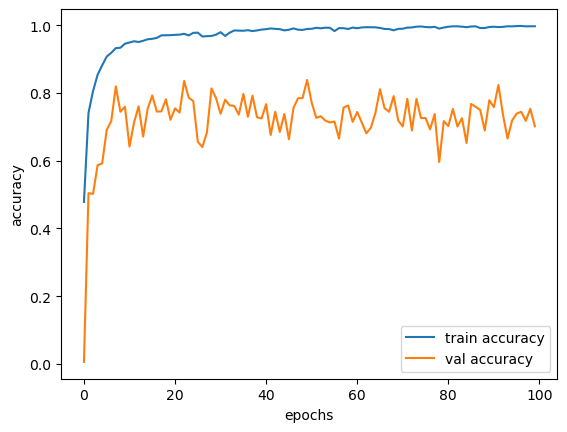

In [324]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [325]:
print(history.history['accuracy'])
print("\n\n")
print(history.history['val_accuracy'])
print("\n\n")
print(len(acc))
print("\n\n")
print(len(val_acc))
print("\n\n")
print(epochs)

[0.4785650372505188, 0.7415897846221924, 0.8060434460639954, 0.8541232347488403, 0.8818100690841675, 0.907710611820221, 0.9190235137939453, 0.9325692057609558, 0.9337600469589233, 0.9456683397293091, 0.9492408633232117, 0.9529622197151184, 0.9507293701171875, 0.9543018937110901, 0.9587674736976624, 0.960107147693634, 0.9627865552902222, 0.9703781008720398, 0.9706758260726929, 0.9709734916687012, 0.9718666076660156, 0.9724620580673218, 0.974992573261261, 0.9700803756713867, 0.9776719212532043, 0.9784162044525146, 0.9669544696807861, 0.9679964184761047, 0.9685918688774109, 0.9724620580673218, 0.9797558784484863, 0.9685918688774109, 0.9782673120498657, 0.9848169088363647, 0.9843703508377075, 0.9839237928390503, 0.985561192035675, 0.9830306768417358, 0.9848169088363647, 0.987347424030304, 0.9886870980262756, 0.9907710552215576, 0.9894313812255859, 0.9886870980262756, 0.9849657416343689, 0.9869008660316467, 0.9909198880195618, 0.9870496988296509, 0.9864543080329895, 0.9892825484275818, 0.98

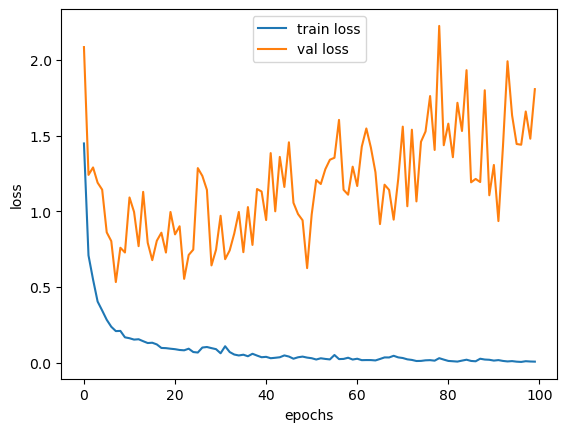

In [326]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [327]:
# Real-time speech emotion recognition
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
sr = 16000
duration = 3
samples = sr * duration

In [328]:
import keras

In [329]:
# Load model
model = keras.models.load_model("/kaggle/working/best_model.h5")

In [330]:
# extracting mfcc features fnx
def extract_mfcc(filename):
    # set duration bcoz all files are of different lengths
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    # using librosa to extract mfcc
    # n_mfcc -> no. of mfcc's to return
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [380]:
# myaudio = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_cheek_angry.wav"
myaudio = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_book_disgust.wav"
# myaudio = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_dead_happy.wav"
# myaudio = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_calm_ps.wav"
# myaudio = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_boat_fear.wav"
# myaudio = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_deep_fear.wav"
mfccAudio = extract_mfcc(myaudio)
mfccAudio

array([-4.9446210e+02,  1.0990865e+02,  2.9442129e+01, -2.3836231e+00,
        9.3993444e+00,  8.7972126e+00, -5.0403917e-01,  1.2835115e+00,
       -1.7557907e+01,  8.8948101e-01, -1.3202542e+01,  3.8483753e+00,
       -4.4069037e+00,  5.2406371e-01,  2.5918028e+00, -2.8048806e+00,
       -4.5366712e+00,  1.5908736e+00, -8.1480511e-02, -3.4143755e+00,
        1.4140072e-01, -4.3393626e+00, -2.9680562e+00, -2.5932167e+00,
       -2.8992901e+00,  3.5178692e+00, -2.4229729e+00,  3.8435755e+00,
        4.6732017e-01,  3.7213788e+00, -3.5355470e-01,  2.8948908e+00,
        7.0256662e-01, -1.2252585e+00,  1.4472544e+00,  4.2722478e+00,
        8.6695404e+00,  1.5064310e+01,  1.6913923e+01,  1.4977526e+01],
      dtype=float32)

In [381]:
# inp = np.array(lst[0][0])
ninp = np.reshape(mfccAudio, (40, 1))
print(ninp)
print(ninp.shape)

[[-4.9446210e+02]
 [ 1.0990865e+02]
 [ 2.9442129e+01]
 [-2.3836231e+00]
 [ 9.3993444e+00]
 [ 8.7972126e+00]
 [-5.0403917e-01]
 [ 1.2835115e+00]
 [-1.7557907e+01]
 [ 8.8948101e-01]
 [-1.3202542e+01]
 [ 3.8483753e+00]
 [-4.4069037e+00]
 [ 5.2406371e-01]
 [ 2.5918028e+00]
 [-2.8048806e+00]
 [-4.5366712e+00]
 [ 1.5908736e+00]
 [-8.1480511e-02]
 [-3.4143755e+00]
 [ 1.4140072e-01]
 [-4.3393626e+00]
 [-2.9680562e+00]
 [-2.5932167e+00]
 [-2.8992901e+00]
 [ 3.5178692e+00]
 [-2.4229729e+00]
 [ 3.8435755e+00]
 [ 4.6732017e-01]
 [ 3.7213788e+00]
 [-3.5355470e-01]
 [ 2.8948908e+00]
 [ 7.0256662e-01]
 [-1.2252585e+00]
 [ 1.4472544e+00]
 [ 4.2722478e+00]
 [ 8.6695404e+00]
 [ 1.5064310e+01]
 [ 1.6913923e+01]
 [ 1.4977526e+01]]
(40, 1)


In [382]:
predictions = model.predict(ninp)
emotion = np.argmax(predictions)
print("Emotion is: ", emotion)

2/2 [==============================] - 0s 4ms/step
Emotion is:  11


In [384]:
predictions_list = []
sumi = 0
for i in range(40):
    index = np.argmax(predictions[i])
    sumi = sumi + index
    predictions_list.append(index)
print('Avg = ', sumi/40)
lists = np.array(predictions_list)

Avg =  2.95


In [385]:
import numpy as np
from scipy import stats

# Calculate the mode
mode = stats.mode(lists)

# Print the mode
print(mode)
print("Mode:", mode.mode)

ModeResult(mode=array([2]), count=array([18]))
Mode: [2]


/tmp/ipykernel_28/3390448982.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(lists)


In [386]:
print(predictions[11])

[0.08249746 0.20486815 0.07391942 0.09244937 0.09879116 0.19848739
 0.2489871 ]


In [ ]:
# Surprise = 3.42
# Fear = 3.0, 3.2
# Angry = 3.85
# Disguist = 2.95

In [387]:
# print(predictions[10])
index = 0
sum = 0
maxmax_index = 0
maximaxi = 0
for i in range(40):
    maxi = 0
    index = 0
    max_index = 0
    for j in predictions[i]:
        if (maxi < j):
            maxi = j
            max_index = index
        index = index + 1
    sum = sum + max_index
    if maximaxi < maxi:
        maximaxi = maxi
        maxmax_index = max_index
    print(maxi)
    print(max_index)
print("Sum", sum)
print("Avg", sum/40)
print("Final maximaxi: ", maximaxi)
print("Emotion: ",maxmax_index)

0.63699627
2
0.9999012
4
0.9957612
4
0.4581
2
0.41347617
6
0.41416413
6
0.2598198
2
0.1923784
1
0.9404734
2
0.18867105
1
0.92151225
2
0.2489871
6
0.6519582
2
0.18376008
1
0.20296746
1
0.5028654
2
0.66221106
2
0.19501613
1
0.22232093
2
0.5642558
2
0.20045827
2
0.6465071
2
0.519795
2
0.48053214
2
0.51269513
2
0.23622647
6
0.46233103
2
0.24880193
6
0.18233258
1
0.24406734
6
0.24574552
2
0.21292304
6
0.18687487
1
0.33330986
2
0.19379584
1
0.26579365
6
0.41340885
6
0.72567695
4
0.8566489
4
0.7178951
4
Sum 118
Avg 2.95
Final maximaxi:  0.9999012
Emotion:  4


In [337]:
predictions.shape

(40, 7)

In [374]:
# Print the predicted emotion
emo_list = {
    0: 'Fear',
    1: 'Angry',
    2: 'Disgust',
    3: 'Neutral',
    4: 'Sad',
    5: 'Surprise',
    6: 'Happy'
}
print("Predicted Emotion: {}".format(emo_list[emotion]))

In [ ]:
# total_predictions = []
# predictions = model.predict(ninp, use_multiprocessing=True)
# pred_list = list(predictions)
# pred_np = np.squeeze(np.array(pred_list).tolist()) # Get rid of 'array' & 'dtype' statments.
# total_predictions.append(pred_np)
    
# # Present emotion distribution for a sequence (7.1 secs).
# # fig = plt.figure(figsize = (10, 2))
# # plt.bar(emo_list, pred_np, color = 'darkturquoise')
# # plt.ylabel("Probabilty (%)")
# # plt.show()
    
# max_emo = np.argmax(predictions)
# print(max_emo)
# print('max emotion:', emotions.get(max_emo,-1))
# print(100*'-')

In [ ]:
# !pip install SpeechRecognition
# !pip install PyAudio

In [ ]:
# import speech_recognition as s_r
# print(s_r.__version__) # just to print the version not required
# r = s_r.Recognizer()
# my_mic = s_r.Microphone(device_index=1) #my device index is 1, you have to put your device index
# with my_mic as source:
#     print("Say now!!!!")
#     audio = r.listen(source) #take voice input from the microphone
# # recognize speech using Google Speech Recognition
# try:
#     # for testing purposes, we're just using the default API key
#     # to use another API key, use `r.recognize_google(audio, key="GOOGLE_SPEECH_RECOGNITION_API_KEY")`
#     # instead of `r.recognize_google(audio)`
#     print("Google Speech Recognition thinks you said " + r.recognize_google(audio))
# except sr.UnknownValueError:
#     print("Google Speech Recognition could not understand audio")
# except sr.RequestError as e:
#     print("Could not request results from Google Speech Recognition service; {0}".format(e))